# Semantic analysis of juridic texts

This notebook shows an example of using word2vec representation and machine learning to make semantic analysis of juridic petition text that are written in portuguese. 

Author: Victor Liberalino

Adapted from [Siraj Raval](https://github.com/llSourcell/word_vectors_game_of_thrones-LIVE)

In [3]:
from __future__ import absolute_import, division, print_function # bridge between python 2 and 3

In [4]:
import codecs # Wrd encoding
import logging # Log info
import multiprocessing # Concurrency
import os # Operating system functions
import pprint # easy visualisation
import re # Regular expressions
import nltk # Natural language processing toolkit

In [5]:
import gensim.models.word2vec as w2v # Word to vectors
import sklearn.manifold # Dimensionality reduction
import numpy as np # Maths
import matplotlib.pyplot as plt # Plotting
import pandas as pd # Data structures
import seaborn as sns # Visualization

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [8]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/victor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Note**: The data here is a sample of 100 petitions. In a real system, this should be done with a bigger dataset.

In [98]:
# Create list of petitions
path = '../data/petitions/'
petitions = []
for i, file in enumerate(os.listdir(path)):
    if file.endswith(".txt"):
#         file = os.rename(path+file,'{}pet{}.txt'.format(path,i))
        petitions.append(file)

In [99]:
petitions

['pet36.txt',
 'pet74.txt',
 'pet76.txt',
 'pet61.txt',
 'pet38.txt',
 'pet32.txt',
 'pet0.txt',
 'pet85.txt',
 'pet27.txt',
 'pet86.txt',
 'pet62.txt',
 'pet63.txt',
 'pet25.txt',
 'pet75.txt',
 'pet22.txt',
 'pet94.txt',
 'pet30.txt',
 'pet29.txt',
 'pet55.txt',
 'pet9.txt',
 'pet90.txt',
 'pet20.txt',
 'pet80.txt',
 'pet15.txt',
 'pet45.txt',
 'pet73.txt',
 'pet28.txt',
 'pet18.txt',
 'pet95.txt',
 'pet34.txt',
 'pet56.txt',
 'pet37.txt',
 'pet50.txt',
 'pet93.txt',
 'pet7.txt',
 'pet12.txt',
 'pet1.txt',
 'pet98.txt',
 'pet10.txt',
 'pet21.txt',
 'pet67.txt',
 'pet83.txt',
 'pet91.txt',
 'pet42.txt',
 'pet49.txt',
 'pet46.txt',
 'pet69.txt',
 'pet58.txt',
 'pet77.txt',
 'pet13.txt',
 'pet14.txt',
 'pet11.txt',
 'pet19.txt',
 'pet71.txt',
 'pet47.txt',
 'pet96.txt',
 'pet51.txt',
 'pet39.txt',
 'pet33.txt',
 'pet57.txt',
 'pet66.txt',
 'pet81.txt',
 'pet53.txt',
 'pet99.txt',
 'pet88.txt',
 'pet65.txt',
 'pet23.txt',
 'pet87.txt',
 'pet8.txt',
 'pet92.txt',
 'pet89.txt',
 'pet24.txt

In [100]:
# Here all the petitions are preprocessed to remove possible personal information
for petition in petitions:
    with open(path+petition, "r") as pet:
        x = pet.read()
        x = re.sub(r'\.+', '\.', x)
        x = re.sub(r"www\S+|http\S+", "", x, flags=re.IGNORECASE) #URLs
        x = re.sub(r"\S{2,}@\S{2,}\.[a-z]+", "", x, flags=re.IGNORECASE) #e-mails
        x = re.sub(r'[A-ZÁÉÍÓÚÂÊĨÔÛÃẼĨÕŨÇ][a-záéíóúâêîôûãẽĩõũç]+|\d+', '', x) # Names and numbers
        x = re.sub(r"(R\$\.)", "", x, flags=re.IGNORECASE) # Real monetary unit
        x = re.sub(r'[^\w\s\.\-:;()\"\']', "", x, flags=re.IGNORECASE) # Special characters
        x = re.sub(r'([A-ZÁÉÍÓÚÀÈÌÒÙÃẼĨÕŨÂÊÎÔÛÇÜ]+)', '', x) # Upper-case words.
    with open(path+petition,'w') as pet:
           pet.write(x)

**Note**: The preprocessing could be less restrictive to get better results. I chose to do this way here to ensure that the identity of people will not be exposed.

In [101]:
# Putting all petitions together in a corpus
corpus_raw = u""
for petition in petitions:
    print("Reading '{0}'...".format(petition))
    with codecs.open(path+petition, "r", "utf-8") as pet:
        corpus_raw += pet.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'pet36.txt'...
Corpus is now 5573 characters long

Reading 'pet74.txt'...
Corpus is now 13907 characters long

Reading 'pet76.txt'...
Corpus is now 15819 characters long

Reading 'pet61.txt'...
Corpus is now 35627 characters long

Reading 'pet38.txt'...
Corpus is now 38290 characters long

Reading 'pet32.txt'...
Corpus is now 57161 characters long

Reading 'pet0.txt'...
Corpus is now 59846 characters long

Reading 'pet85.txt'...
Corpus is now 72317 characters long

Reading 'pet27.txt'...
Corpus is now 74030 characters long

Reading 'pet86.txt'...
Corpus is now 84186 characters long

Reading 'pet62.txt'...
Corpus is now 87143 characters long

Reading 'pet63.txt'...
Corpus is now 105612 characters long

Reading 'pet25.txt'...
Corpus is now 129381 characters long

Reading 'pet75.txt'...
Corpus is now 149919 characters long

Reading 'pet22.txt'...
Corpus is now 152570 characters long

Reading 'pet94.txt'...
Corpus is now 155738 characters long

Reading 'pet30.txt'...
Corpus is now 

In [102]:
tokenizer = nltk.data.load('tokenizers/punkt/portuguese.pickle')

In [168]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [104]:
def sentence_to_wordlist(raw):
    clean = re.sub(r"[^\wáéíóúãẽĩõũâêîôûç]"," ", raw)
    words = clean.split()
    return words

In [90]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [91]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

que a  percebeu que estava sendo cobrada mais do
que deveria e ao entrar em contato com a  tomou a ciência de que a fatura do mês de 
de  estava em aberto.
['que', 'a', 'percebeu', 'que', 'estava', 'sendo', 'cobrada', 'mais', 'do', 'que', 'deveria', 'e', 'ao', 'entrar', 'em', 'contato', 'com', 'a', 'tomou', 'a', 'ciência', 'de', 'que', 'a', 'fatura', 'do', 'mês', 'de', 'de', 'estava', 'em', 'aberto']


In [92]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 122,364 tokens


In [93]:


#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 1000
# Minimum word count threshold.
min_word_count = 5

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 10

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1



In [94]:
justice2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [95]:
justice2vec.build_vocab(sentences)

2018-05-26 21:21:43,147 : INFO : collecting all words and their counts
2018-05-26 21:21:43,149 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-26 21:21:43,216 : INFO : collected 9337 word types from a corpus of 122364 raw words and 7612 sentences
2018-05-26 21:21:43,221 : INFO : Loading a fresh vocabulary
2018-05-26 21:21:43,238 : INFO : min_count=5 retains 2576 unique words (27% of original 9337, drops 6761)
2018-05-26 21:21:43,243 : INFO : min_count=5 leaves 111101 word corpus (90% of original 122364, drops 11263)
2018-05-26 21:21:43,276 : INFO : deleting the raw counts dictionary of 9337 items
2018-05-26 21:21:43,283 : INFO : sample=0.001 downsamples 43 most-common words
2018-05-26 21:21:43,287 : INFO : downsampling leaves estimated 77180 word corpus (69.5% of prior 111101)
2018-05-26 21:21:43,305 : INFO : estimated required memory for 2576 words and 1000 dimensions: 21896000 bytes
2018-05-26 21:21:43,312 : INFO : resetting layer weights


In [96]:
print("Word2Vec vocabulary length:", len(justice2vec.wv.vocab))

Word2Vec vocabulary length: 2576


In [97]:
justice2vec.train(sentences, total_examples=justice2vec.corpus_count, epochs=300)

2018-05-26 21:21:46,776 : INFO : training model with 2 workers on 2576 vocabulary and 1000 features, using sg=1 hs=0 sample=0.001 negative=5 window=10
2018-05-26 21:21:48,093 : INFO : EPOCH 1 - PROGRESS: at 58.25% examples, 34136 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:21:48,736 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:21:48,773 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:21:48,777 : INFO : EPOCH - 1 : training on 122364 raw words (77148 effective words) took 2.0s, 39040 effective words/s
2018-05-26 21:21:49,883 : INFO : EPOCH 2 - PROGRESS: at 58.25% examples, 40040 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:21:50,452 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:21:50,488 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:21:50,491 : INFO : EPOCH - 2 : training on 122364 raw words (77142 effective words) took 1.7s, 45236 effective wor

2018-05-26 21:22:23,730 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:22:23,736 : INFO : EPOCH - 18 : training on 122364 raw words (77051 effective words) took 2.8s, 27427 effective words/s
2018-05-26 21:22:24,819 : INFO : EPOCH 19 - PROGRESS: at 40.94% examples, 29326 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:22:25,855 : INFO : EPOCH 19 - PROGRESS: at 80.82% examples, 29825 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:22:26,050 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:22:26,179 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:22:26,183 : INFO : EPOCH - 19 : training on 122364 raw words (77173 effective words) took 2.4s, 31688 effective words/s
2018-05-26 21:22:27,366 : INFO : EPOCH 20 - PROGRESS: at 40.94% examples, 26779 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:22:28,408 : INFO : EPOCH 20 - PROGRESS: at 90.50% examples, 31144 words/s, in_qsize 2, out_qsize 0
2018-05

2018-05-26 21:23:00,267 : INFO : EPOCH - 33 : training on 122364 raw words (77167 effective words) took 2.4s, 32182 effective words/s
2018-05-26 21:23:01,285 : INFO : EPOCH 34 - PROGRESS: at 40.94% examples, 31452 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:23:02,442 : INFO : EPOCH 34 - PROGRESS: at 90.50% examples, 31997 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:23:02,541 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:23:02,581 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:23:02,586 : INFO : EPOCH - 34 : training on 122364 raw words (77246 effective words) took 2.3s, 33541 effective words/s
2018-05-26 21:23:03,686 : INFO : EPOCH 35 - PROGRESS: at 40.94% examples, 29056 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:23:04,897 : INFO : EPOCH 35 - PROGRESS: at 90.50% examples, 30060 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:23:05,004 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05

2018-05-26 21:23:42,715 : INFO : EPOCH 48 - PROGRESS: at 90.50% examples, 28378 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:23:42,831 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:23:42,853 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:23:42,854 : INFO : EPOCH - 48 : training on 122364 raw words (77023 effective words) took 2.6s, 30013 effective words/s
2018-05-26 21:23:43,986 : INFO : EPOCH 49 - PROGRESS: at 40.94% examples, 28427 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:23:45,387 : INFO : EPOCH 49 - PROGRESS: at 90.50% examples, 27536 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:23:45,527 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:23:45,563 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:23:45,564 : INFO : EPOCH - 49 : training on 122364 raw words (77164 effective words) took 2.7s, 28748 effective words/s
2018-05-26 21:23:46,623 : INF

2018-05-26 21:24:22,302 : INFO : EPOCH 63 - PROGRESS: at 58.25% examples, 20764 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:24:23,419 : INFO : EPOCH 63 - PROGRESS: at 92.31% examples, 21848 words/s, in_qsize 1, out_qsize 1
2018-05-26 21:24:23,420 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:24:23,494 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:24:23,496 : INFO : EPOCH - 63 : training on 122364 raw words (77238 effective words) took 3.3s, 23260 effective words/s
2018-05-26 21:24:24,777 : INFO : EPOCH 64 - PROGRESS: at 58.25% examples, 34838 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:24:25,597 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:24:25,715 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:24:25,725 : INFO : EPOCH - 64 : training on 122364 raw words (77209 effective words) took 2.2s, 34839 effective words/s
2018-05-26 21:24:26,918 : INF

2018-05-26 21:25:02,695 : INFO : EPOCH 78 - PROGRESS: at 40.94% examples, 31290 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:25:03,746 : INFO : EPOCH 78 - PROGRESS: at 90.50% examples, 33590 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:25:03,896 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:25:03,915 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:25:03,920 : INFO : EPOCH - 78 : training on 122364 raw words (77099 effective words) took 2.2s, 34618 effective words/s
2018-05-26 21:25:05,112 : INFO : EPOCH 79 - PROGRESS: at 40.94% examples, 27545 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:25:06,274 : INFO : EPOCH 79 - PROGRESS: at 72.64% examples, 24593 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:25:06,843 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:25:06,899 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:25:06,904 : INFO : EPOCH - 79 : trai

2018-05-26 21:25:43,819 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:25:43,852 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:25:43,855 : INFO : EPOCH - 92 : training on 122364 raw words (77229 effective words) took 3.5s, 22190 effective words/s
2018-05-26 21:25:44,932 : INFO : EPOCH 93 - PROGRESS: at 24.33% examples, 17668 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:25:46,141 : INFO : EPOCH 93 - PROGRESS: at 58.25% examples, 19483 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:25:47,185 : INFO : EPOCH 93 - PROGRESS: at 90.50% examples, 20871 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:25:47,345 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:25:47,414 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:25:47,417 : INFO : EPOCH - 93 : training on 122364 raw words (77370 effective words) took 3.5s, 21804 effective words/s
2018-05-26 21:25:48,541 : INF

2018-05-26 21:26:22,751 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:26:22,850 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:26:22,853 : INFO : EPOCH - 107 : training on 122364 raw words (77288 effective words) took 2.3s, 33027 effective words/s
2018-05-26 21:26:24,175 : INFO : EPOCH 108 - PROGRESS: at 31.91% examples, 19441 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:26:25,284 : INFO : EPOCH 108 - PROGRESS: at 65.90% examples, 21008 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:26:26,302 : INFO : EPOCH 108 - PROGRESS: at 92.31% examples, 20674 words/s, in_qsize 1, out_qsize 1
2018-05-26 21:26:26,307 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:26:26,405 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:26:26,407 : INFO : EPOCH - 108 : training on 122364 raw words (77095 effective words) took 3.5s, 21851 effective words/s
2018-05-26 21:26:27,446 

2018-05-26 21:27:02,925 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:27:02,929 : INFO : EPOCH - 122 : training on 122364 raw words (77355 effective words) took 2.9s, 26402 effective words/s
2018-05-26 21:27:04,011 : INFO : EPOCH 123 - PROGRESS: at 24.33% examples, 17622 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:27:05,135 : INFO : EPOCH 123 - PROGRESS: at 65.90% examples, 23092 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:27:05,995 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:27:06,014 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:27:06,023 : INFO : EPOCH - 123 : training on 122364 raw words (77344 effective words) took 3.1s, 25115 effective words/s
2018-05-26 21:27:07,066 : INFO : EPOCH 124 - PROGRESS: at 24.33% examples, 18155 words/s, in_qsize 4, out_qsize 1
2018-05-26 21:27:08,090 : INFO : EPOCH 124 - PROGRESS: at 58.25% examples, 21459 words/s, in_qsize 3, out_qsize 0
2

2018-05-26 21:27:42,602 : INFO : EPOCH - 137 : training on 122364 raw words (76942 effective words) took 2.5s, 30405 effective words/s
2018-05-26 21:27:43,649 : INFO : EPOCH 138 - PROGRESS: at 31.91% examples, 24683 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:27:44,863 : INFO : EPOCH 138 - PROGRESS: at 72.64% examples, 25360 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:27:45,353 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:27:45,391 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:27:45,395 : INFO : EPOCH - 138 : training on 122364 raw words (77202 effective words) took 2.8s, 27883 effective words/s
2018-05-26 21:27:46,743 : INFO : EPOCH 139 - PROGRESS: at 39.88% examples, 23600 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:27:47,870 : INFO : EPOCH 139 - PROGRESS: at 88.50% examples, 28120 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:27:47,960 : INFO : worker thread finished; awaiting finish of 1 more threads
2

2018-05-26 21:28:21,627 : INFO : EPOCH 153 - PROGRESS: at 90.50% examples, 30316 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:28:21,728 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:28:21,741 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:28:21,746 : INFO : EPOCH - 153 : training on 122364 raw words (77214 effective words) took 2.4s, 32209 effective words/s
2018-05-26 21:28:22,834 : INFO : EPOCH 154 - PROGRESS: at 31.91% examples, 23350 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:28:23,967 : INFO : EPOCH 154 - PROGRESS: at 72.64% examples, 25590 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:28:24,441 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:28:24,490 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:28:24,494 : INFO : EPOCH - 154 : training on 122364 raw words (77222 effective words) took 2.7s, 28181 effective words/s
2018-05-26 21:28:25,646 

2018-05-26 21:28:57,620 : INFO : EPOCH - 169 : training on 122364 raw words (77209 effective words) took 2.3s, 32956 effective words/s
2018-05-26 21:28:58,896 : INFO : EPOCH 170 - PROGRESS: at 40.94% examples, 25092 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:29:00,007 : INFO : EPOCH 170 - PROGRESS: at 90.50% examples, 29257 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:29:00,156 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:29:00,268 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:29:00,274 : INFO : EPOCH - 170 : training on 122364 raw words (77364 effective words) took 2.6s, 29365 effective words/s
2018-05-26 21:29:01,360 : INFO : EPOCH 171 - PROGRESS: at 31.91% examples, 23513 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:29:02,392 : INFO : EPOCH 171 - PROGRESS: at 58.25% examples, 21007 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:29:03,222 : INFO : worker thread finished; awaiting finish of 1 more threads
2

2018-05-26 21:29:38,198 : INFO : EPOCH 185 - PROGRESS: at 40.94% examples, 27180 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:29:39,297 : INFO : EPOCH 185 - PROGRESS: at 80.82% examples, 27854 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:29:39,667 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:29:39,709 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:29:39,710 : INFO : EPOCH - 185 : training on 122364 raw words (77252 effective words) took 2.7s, 28950 effective words/s
2018-05-26 21:29:41,046 : INFO : EPOCH 186 - PROGRESS: at 39.88% examples, 23879 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:29:42,249 : INFO : EPOCH 186 - PROGRESS: at 90.50% examples, 27375 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:29:42,297 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:29:42,381 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:29:42,385 : INFO : EPOCH - 186 

2018-05-26 21:30:17,838 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:30:18,002 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:30:18,006 : INFO : EPOCH - 200 : training on 122364 raw words (77037 effective words) took 2.4s, 31484 effective words/s
2018-05-26 21:30:19,026 : INFO : EPOCH 201 - PROGRESS: at 33.36% examples, 24910 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:30:20,066 : INFO : EPOCH 201 - PROGRESS: at 80.82% examples, 30731 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:30:20,272 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:30:20,425 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:30:20,429 : INFO : EPOCH - 201 : training on 122364 raw words (77203 effective words) took 2.4s, 32091 effective words/s
2018-05-26 21:30:21,614 : INFO : EPOCH 202 - PROGRESS: at 48.91% examples, 32080 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:30:22,458 

2018-05-26 21:30:55,980 : INFO : EPOCH - 216 : training on 122364 raw words (76965 effective words) took 1.9s, 40967 effective words/s
2018-05-26 21:30:57,153 : INFO : EPOCH 217 - PROGRESS: at 58.25% examples, 38466 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:30:57,843 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:30:57,867 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:30:57,879 : INFO : EPOCH - 217 : training on 122364 raw words (77297 effective words) took 1.9s, 41180 effective words/s
2018-05-26 21:30:58,909 : INFO : EPOCH 218 - PROGRESS: at 48.91% examples, 37074 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:30:59,969 : INFO : EPOCH 218 - PROGRESS: at 92.31% examples, 34099 words/s, in_qsize 1, out_qsize 1
2018-05-26 21:30:59,970 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:31:00,105 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:31:00,108 

2018-05-26 21:31:34,698 : INFO : EPOCH - 232 : training on 122364 raw words (77168 effective words) took 2.0s, 38494 effective words/s
2018-05-26 21:31:35,938 : INFO : EPOCH 233 - PROGRESS: at 58.25% examples, 35905 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:31:36,832 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:31:37,006 : INFO : EPOCH 233 - PROGRESS: at 100.00% examples, 33555 words/s, in_qsize 0, out_qsize 1
2018-05-26 21:31:37,007 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:31:37,015 : INFO : EPOCH - 233 : training on 122364 raw words (77006 effective words) took 2.3s, 33418 effective words/s
2018-05-26 21:31:38,035 : INFO : EPOCH 234 - PROGRESS: at 31.91% examples, 25044 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:31:39,039 : INFO : EPOCH 234 - PROGRESS: at 72.64% examples, 28196 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:31:39,622 : INFO : worker thread finished; awaiting finish of 1 more threads


2018-05-26 21:32:14,077 : INFO : EPOCH 248 - PROGRESS: at 48.91% examples, 35400 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:32:15,159 : INFO : EPOCH 248 - PROGRESS: at 90.50% examples, 32103 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:32:15,248 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:32:15,300 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:32:15,307 : INFO : EPOCH - 248 : training on 122364 raw words (77088 effective words) took 2.3s, 33595 effective words/s
2018-05-26 21:32:16,323 : INFO : EPOCH 249 - PROGRESS: at 40.94% examples, 31280 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:32:17,395 : INFO : EPOCH 249 - PROGRESS: at 82.32% examples, 30314 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:32:17,727 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:32:17,830 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:32:17,835 : INFO : EPOCH - 249 

2018-05-26 21:32:50,605 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:32:50,611 : INFO : EPOCH - 263 : training on 122364 raw words (77164 effective words) took 2.1s, 37249 effective words/s
2018-05-26 21:32:51,681 : INFO : EPOCH 264 - PROGRESS: at 48.91% examples, 35844 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:32:52,673 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:32:52,690 : INFO : EPOCH 264 - PROGRESS: at 100.00% examples, 37328 words/s, in_qsize 0, out_qsize 1
2018-05-26 21:32:52,696 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:32:52,698 : INFO : EPOCH - 264 : training on 122364 raw words (77196 effective words) took 2.1s, 37192 effective words/s
2018-05-26 21:32:53,765 : INFO : EPOCH 265 - PROGRESS: at 48.91% examples, 35666 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:32:54,741 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:32:54,797

2018-05-26 21:33:26,994 : INFO : EPOCH - 279 : training on 122364 raw words (77227 effective words) took 2.8s, 27648 effective words/s
2018-05-26 21:33:28,103 : INFO : EPOCH 280 - PROGRESS: at 40.94% examples, 28700 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:33:29,383 : INFO : EPOCH 280 - PROGRESS: at 80.82% examples, 26417 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:33:29,624 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:33:29,676 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:33:29,677 : INFO : EPOCH - 280 : training on 122364 raw words (77157 effective words) took 2.7s, 28897 effective words/s
2018-05-26 21:33:30,739 : INFO : EPOCH 281 - PROGRESS: at 39.88% examples, 30441 words/s, in_qsize 4, out_qsize 0
2018-05-26 21:33:31,804 : INFO : EPOCH 281 - PROGRESS: at 90.50% examples, 32831 words/s, in_qsize 2, out_qsize 0
2018-05-26 21:33:31,890 : INFO : worker thread finished; awaiting finish of 1 more threads
2

2018-05-26 21:34:04,879 : INFO : EPOCH 295 - PROGRESS: at 98.19% examples, 31971 words/s, in_qsize 1, out_qsize 1
2018-05-26 21:34:04,891 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:34:04,943 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:34:04,944 : INFO : EPOCH - 295 : training on 122364 raw words (77184 effective words) took 2.4s, 31842 effective words/s
2018-05-26 21:34:06,088 : INFO : EPOCH 296 - PROGRESS: at 40.94% examples, 27939 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:34:07,139 : INFO : EPOCH 296 - PROGRESS: at 80.82% examples, 28861 words/s, in_qsize 3, out_qsize 0
2018-05-26 21:34:07,647 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-26 21:34:07,656 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-26 21:34:07,659 : INFO : EPOCH - 296 : training on 122364 raw words (77237 effective words) took 2.7s, 28608 effective words/s
2018-05-26 21:34:08,756 

(23155497, 36709200)

In [106]:
if not os.path.exists(path+"../trained"):
    os.makedirs(path+"../trained")

In [107]:
justice2vec.save(os.path.join(path+"../trained", "justice2vec.w2v"))

2018-05-26 21:36:12,242 : INFO : saving Word2Vec object under ../data/petitions/../trained/justice2vec.w2v, separately None
2018-05-26 21:36:12,245 : INFO : not storing attribute vectors_norm
2018-05-26 21:36:12,247 : INFO : not storing attribute cum_table
2018-05-26 21:36:12,464 : INFO : saved ../data/petitions/../trained/justice2vec.w2v


In [108]:
# Explore the model
thrones2vec = w2v.Word2Vec.load(os.path.join(path+"../trained", "justice2vec.w2v"))

2018-05-26 21:36:16,119 : INFO : loading Word2Vec object from ../data/petitions/../trained/justice2vec.w2v
2018-05-26 21:36:16,390 : INFO : loading wv recursively from ../data/petitions/../trained/justice2vec.w2v.wv.* with mmap=None
2018-05-26 21:36:16,391 : INFO : setting ignored attribute vectors_norm to None
2018-05-26 21:36:16,392 : INFO : loading vocabulary recursively from ../data/petitions/../trained/justice2vec.w2v.vocabulary.* with mmap=None
2018-05-26 21:36:16,393 : INFO : loading trainables recursively from ../data/petitions/../trained/justice2vec.w2v.trainables.* with mmap=None
2018-05-26 21:36:16,394 : INFO : setting ignored attribute cum_table to None
2018-05-26 21:36:16,395 : INFO : loaded ../data/petitions/../trained/justice2vec.w2v


In [109]:
# Visualize a dataset easily in 2D
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [110]:
all_word_vectors_matrix = justice2vec.wv.vectors

In [111]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [112]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[justice2vec.wv.vocab[word].index])
            for word in justice2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [123]:
points.head()

,word,x,y
0,brasileira,0.389735,-3.074158
1,viúva,0.535589,-2.983386
2,portadora,0.437737,-3.071068
3,da,1.766481,0.978877
4,de,1.778458,0.947300


In [124]:
sns.set_context("poster")

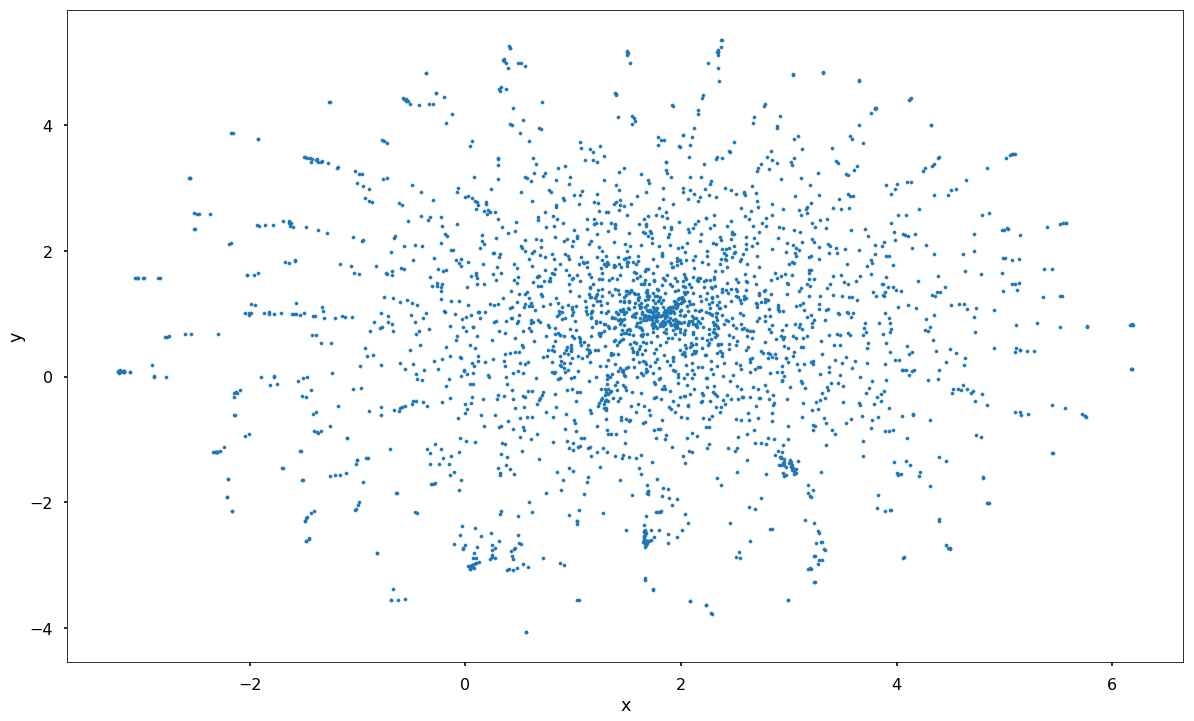

In [125]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [126]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

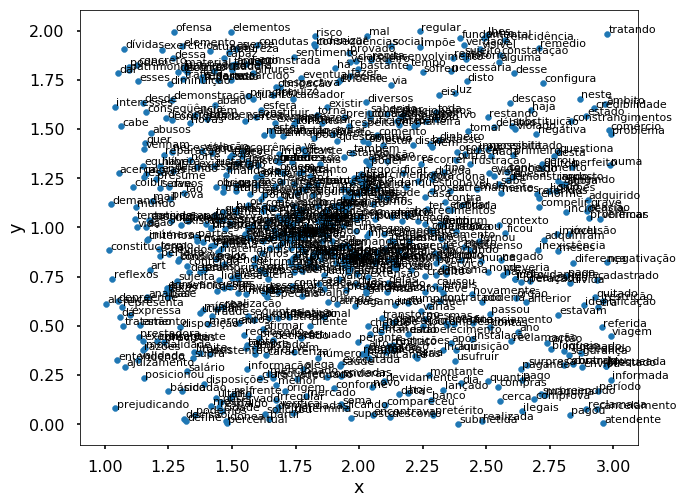

In [127]:
plot_region(x_bounds=(1, 3), y_bounds=(0, 2))

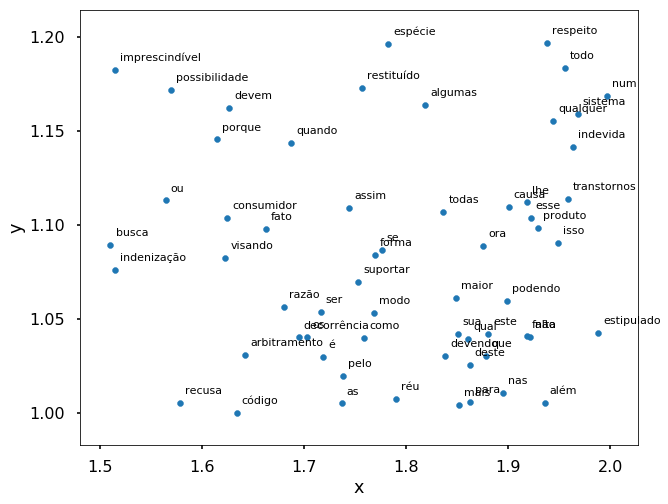

In [128]:
plot_region(x_bounds=(1.5, 2), y_bounds=(1, 1.2))

# Semantic similarities

In [129]:

justice2vec.most_similar("casa")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('loteamento', 0.35243791341781616),
 ('eletrodomésticos', 0.3273642659187317),
 ('semana', 0.2931707501411438),
 ('condomínio', 0.28850650787353516),
 ('adquiriram', 0.28566139936447144),
 ('mostrou', 0.28396040201187134),
 ('construtora', 0.2797592282295227),
 ('poucos', 0.27914607524871826),
 ('pronto', 0.277707576751709),
 ('dormir', 0.27498045563697815)]

In [130]:
justice2vec.most_similar("energia")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('elétrica', 0.7422357797622681),
 ('fornecimento', 0.468820720911026),
 ('suspensão', 0.3229098320007324),
 ('corte', 0.28690242767333984),
 ('essencial', 0.281451553106308),
 ('concessionária', 0.2684347331523895),
 ('eletrodomésticos', 0.2598437964916229),
 ('suspenso', 0.25132957100868225),
 ('residência', 0.24675582349300385),
 ('unidade', 0.24357911944389343)]

In [131]:
justice2vec.most_similar("artigo")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('parágrafo', 0.3923695981502533),
 ('inciso', 0.3422548770904541),
 ('º', 0.28178393840789795),
 ('caput', 0.2477622628211975),
 ('incisos', 0.24578504264354706),
 ('dispõe', 0.2419704645872116),
 ('verbis', 0.24064099788665771),
 ('monitoria', 0.23103277385234833),
 ('diploma', 0.2271008938550949),
 ('rel', 0.22578568756580353)]

In [132]:
justice2vec.most_similar("art")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('arts', 0.2413911372423172),
 ('inviolabilidade', 0.23558291792869568),
 ('rel', 0.203585684299469),
 ('portadora', 0.20292842388153076),
 ('contida', 0.19997769594192505),
 ('indicado', 0.19532346725463867),
 ('mandado', 0.1947183907032013),
 ('consagrou', 0.1935652643442154),
 ('assegura', 0.19292616844177246),
 ('concedido', 0.1902678906917572)]

# Linear relationships between word pairs

In [134]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = justice2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [137]:
nearest_similarity_cosmul("energia", "elétrica", "artigo")

energia is related to elétrica, as parágrafo is related to artigo


'parágrafo'

In [158]:
nearest_similarity_cosmul("lei", "artigo", "dever")

lei is related to artigo, as indenizar is related to dever


'indenizar'